# **First (serious) training of a Neural Network!**

**Disclaimer**: large parts of the lab are taken from [Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) by [Soumith Chintala](http://soumith.ch/) and lectures material of [Sebastian Goldt](https://datascience.sissa.it/research-unit/12/theory-of-neural-networks).

In [1]:
### Some starting stuff ####

%matplotlib inline

import numpy as np

import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc("font", **{"size": 12})
plt.rc("lines", linewidth=2.0)
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.markeredgewidth'] = 2

# **Definition of Neural Networks by means of ``PyTorch``**

The ``torch.nn`` package is used to define and train a Neural Network (model definition). The package depends on ``autograd`` that performs the differentiation.

A Neural Network is defined as ``nn.Module`` and its main features are: 
* the layers, 
* the ``forward`` method that process the ``input`` to predict an ``output``.

The main passages of the training procedure are:

- The definition of the neural network and of its learnable parameters (
  weights, bias, regulatirations)
- Perform a prediction over some ``inputs`` by means of a law (weighted layers and activation functions)
- evaluate the loss (i.e. a measure to understand the distance between the prediction and the ``output``)
- use back propagation on the trainable paramters parameters
- update the trainable parameters (gradient descent-based startegies).




**Let us define the Network**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 100)   ### three layers (comment on bias)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)
        # self.apply(self._init_weights)

    """
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()
    """

    def forward(self, x):  ### Forward law ----> prediction
        x = F.relu(self.fc1(x))   
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


seed_num = 0
torch.manual_seed(seed_num)
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


Only the defintion of the function ``forward`` is needed, since the backward is directly defined for you by ``autograd``.
The ``forward`` function is a law where all the Tensors operations are admitted.




Let us give a look to the parameters in ``net.parameters()``

In [3]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # fc1 .weight
print(params[1].size())
print(params[2].size())
print(params[3].size())
print(params[4].size())
print(params[5].size())

6
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


_**Question time!**_: why is the number of parameters 6? We have only three layers...

_** Let give it a try**_: we define a random 28x28 = 784 ``input``.

_**Question time!**_: why do we need a 28x28 = 784 ``input``?



In [4]:
input = torch.randn(1, 784)
out = net(input)
print(out)

tensor([[ 0.1824,  0.0367, -0.1264, -0.1809,  0.0431, -0.0219,  0.0701,  0.0807,
          0.1693, -0.0903]], grad_fn=<AddmmBackward0>)


We now use the function ``zero_grad`` to set the gradient at zero. It is a good practise because for each mini-batch we want to forget the information about the gradient (otherwise it is accumulated).
We now use back propagation over a random gradient.



In [5]:
net.zero_grad()
out.backward(torch.randn(1, 10))

**Be careful!** ``torch.nn`` is able to only work with batches (i.e. more than one ``input`` with some features). If you want to work with a single sample, use the command ``input.unsqueeze(0)`` to add a fake dimension related to the batch size.



**A brief recap: the features we are dealing with are...**  
-  ``torch.Tensor``: the ``PyTorch`` _multi-dimensional array_ that supports ``autograd`` (and, thus, ``backward()`` operation). 
-  ``nn.Module``: it is the _definition of the Neural Network_ with information about parameters, layers and forward law.
-  ``nn.Parameter``: a Tensor with all the parameters (the bias are present by default!) authomatically generated from the layers.

**A brief recap: we...**
* defined the net
* postprocessed the input thanks to the forward law
* have been able to compute gradients

**There is something missing though!**
* The loss,
* the update of the parameters.

# **The Loss**
The loss is a function that evaluates how far the prediction is from the target (i.e. the _known output_ of the dataset). The ``Torch.nn`` has many losses, [give a look](https://pytorch.org/docs/nn.html#loss-functions)!
The most common is the ``nn.MSELoss``, i.e. the mean-squared error
between the prediction and the given data.


In [6]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
print(target.shape)
target = target.view(1, 10)  # make it the same shape as output of the net, you can use target.view(1, -1) [equivalent]
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

torch.Size([10])
tensor(1.3280, grad_fn=<MseLossBackward0>)


# **Backpropagation**

To perform backpropagation on the loss we have to call ``loss.backward()``. But, as already said, first thing first: clear the existing gradients to avoid accumulating existing information.



In [7]:
net.zero_grad()     # zeroes the gradient
print('fc1.bias.grad before backward')
print(net.fc1.bias.grad)

loss.backward()

print('fc1.bias.grad after backward')
print(net.fc1.bias.grad)

fc1.bias.grad before backward
None
fc1.bias.grad after backward
tensor([ 0.0058,  0.0000,  0.0281,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0302, -0.0170,  0.0000, -0.0098,  0.0006,
         0.0120,  0.0000,  0.0000,  0.0000, -0.0157,  0.0286, -0.0168, -0.0034,
         0.0000,  0.0006, -0.0182,  0.0000,  0.0175,  0.0000,  0.0000,  0.0000,
         0.0000, -0.0089,  0.0000, -0.0038,  0.0000,  0.0000,  0.0119, -0.0102,
         0.0000, -0.0144,  0.0266,  0.0000,  0.0079, -0.0142, -0.0155, -0.0121,
         0.0107,  0.0000,  0.0145,  0.0000,  0.0000,  0.0000,  0.0157,  0.0007,
         0.0164,  0.0000,  0.0125, -0.0099, -0.0070,  0.0000, -0.0291,  0.0274,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0381,  0.0000,  0.0083,
         0.0355, -0.0167, -0.0361,  0.0167,  0.0000,  0.0000, -0.0113,  0.0068,
        -0.0195,  0.0000, -0.0136,  0.0000, -0.0003,  0.0317,  0.0495,  0.0291,
         0.0039,  0.0000,  0.0000,  0.0000, -0.0158,  0.

# **The update**

We have seen that the simplest way to update the parameters is the Stochastic Gradient Descent:

     ``weight = weight - learning_rate * weight_gradient``
     ``bias = bias - learning_rate * bias``


We can implement it by hand as

    learning_rate = 0.01
    for p in net.parameters():
        p.data.sub_(p.grad.data * learning_rate)

However, there are many rules to update the parameters: SGD, Nesterov-SGD, Adam, RMSProp, etc.
We can use the package ``torch.optim`` to choose them. The sintax is very simple:



In [8]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

**That'a all folks!**


# **Your Turn: train the MNIST dataset with Pytorch!** 

First of all, let us collect the data from the package ``torchvision``.
Our goal is to train _an image classifier_. Given a hand-written digit, we want to associate a number.

Please, follow these tasks:

1. Load and normalize the training and test dataset (MNIST) using
   ``torchvision`` and visualize them (together).
2. Define the Neural Network ``Net()``.
3. Define the loss function (give a look to ``nn.CrossEntropyLoss()``) and choose an optimizer.
4. Train the Network on the training data.
5. Test the Network on the test data (together).



In [9]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

**Task 1**: In the following we load the data in the ``DataLoader`` that is a peculiar structure that allows many operations on the data in a _smarter way_. See the [documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

**Dataset**: MNIST images. The MNIST dataset contains 28x28 grayscale images of handwritten digits from 0 to 9. The training set has 60,000 samples, the test set has 10,000 samples. The output is an interger label from 0 to 9.

Dataset class in pytorch recasts the data in a tuple in other to create the dataloader class which can be used to shuffle, apply Mini-Batch Gradient Descent and more.



In [10]:

transform = transforms.Compose([transforms.ToTensor()])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 30324059.82it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 11259010.49it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████| 1648877/1648877 [00:00<00:00, 30390171.80it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 2964601.43it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Let us visualize some of the digits.



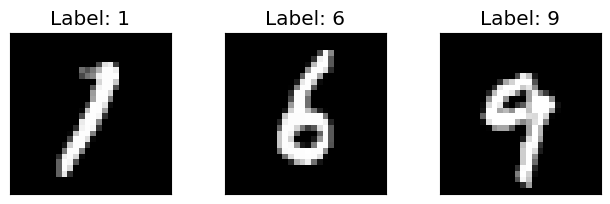

In [11]:
import matplotlib.pyplot as plt

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)


fig = plt.figure()
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])

**Task 2**: define and call ``Net()``, a fully connected feedforward Neural Network made from an input layer (_what is the dimension of the input?_), hidden layers, and an output layer. The structure is [``input_dim``, 100, 50, ``output_dim``] (_what is the dimension of the output?_)
Moreover, the internal neurons have feature a ``Tanh`` _activation function action_, while the output layer is subjected to ``ReLU``.

**Be careful!**: a reshape of the input is needed!

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(28*28, 100)
        self.linear2 = nn.Linear(100,50)
        self.final = nn.Linear(50,10)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        ## self.apply(self._init_weights)

    """
    def HERE YOU CAN DEFINE THE WEIGHTS (look above)
    """
        
    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.tanh(self.linear1(x))
        x = self.tanh(self.linear2(x))
        x = self.relu(self.final(x))

        return x

seed_num = 1
torch.manual_seed(seed_num)
net = Net()

**Task 3 and 4**: define the loss (``nn.CrossEntropyLoss()``) and choose an optimizer (_Let us start with SGD?_). Fix the learning rate.
When we work with mini-batches, we can iterate over the DataLoarder (6000 iterations for a mini-batch of dimention 10) for some epochs, say 10. Complete the following cell.

_Can you trace the loss and plot it with respect to the number of iterations (different from epochs)_?

In [ ]:
my_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
epoch = 10
i = 0

#### Useful quantities ####

train_losses = []


for ep in range(epoch):
    net.train()

    for data in train_loader:
          i += 1
          x, y = data
          ### set zero grad on the optimizer
          optimizer.zero_grad()
          
          ## compute output
          output = net(x)
          # compute the loss
          loss = my_loss(output, y)
          #compute the gradients
          loss.backward()
          # optimizer update
          optimizer.step()
          if i % 200 == 199:    # print every 10*200 = 2000 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (ep + 1, i + 1, loss.item()))
              running_loss = 0.0
              train_losses.append(loss.item())
    # i = 0

[1,   200] loss: 2.201
[1,   400] loss: 1.749
[1,   600] loss: 2.188
[1,   800] loss: 1.706
[1,  1000] loss: 0.994
[1,  1200] loss: 0.990
[1,  1400] loss: 0.557
[1,  1600] loss: 1.403
[1,  1800] loss: 0.543
[1,  2000] loss: 0.528
[1,  2200] loss: 0.424
[1,  2400] loss: 0.459
[1,  2600] loss: 0.362
[1,  2800] loss: 0.370
[1,  3000] loss: 0.129
[1,  3200] loss: 0.476
[1,  3400] loss: 0.272
[1,  3600] loss: 0.233
[1,  3800] loss: 0.362
[1,  4000] loss: 0.245
[1,  4200] loss: 0.349
[1,  4400] loss: 0.206
[1,  4600] loss: 0.203
[1,  4800] loss: 0.061
[1,  5000] loss: 0.270
[1,  5200] loss: 0.137
[1,  5400] loss: 0.120
[1,  5600] loss: 0.183
[1,  5800] loss: 0.252
[1,  6000] loss: 0.147
[2,  6200] loss: 0.181
[2,  6400] loss: 0.223
[2,  6600] loss: 0.503
[2,  6800] loss: 0.146
[2,  7000] loss: 0.164
[2,  7200] loss: 0.071
[2,  7400] loss: 1.029
[2,  7600] loss: 0.358
[2,  7800] loss: 0.050
[2,  8000] loss: 0.305
[2,  8200] loss: 0.211
[2,  8400] loss: 0.307
[2,  8600] loss: 0.169
[2,  8800] 

In [ ]:
fig = plt.figure()
plt.semilogy(range(len(train_losses)), train_losses, color='magenta')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylabel('Loss')


**Task 5**: let us check how accurate is the model and which classes perform better!

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        x, y = data
        output = net(x)
        # print(output)
        
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:  #### idx indicates which sample I am taking from the mini-batch. The Output is a a vector of floats, the biggest is the one with higher probability
                correct +=1
            total +=1

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
plt.imshow(x[3].view(28, 28))
plt.show()
print(torch.argmax(net(x[3].view(-1, 784))[0]))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.reshape(-1, 784)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1) ### returning the indices
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))